# LFADS IMPLEMENTATION 
## Most LFADS scripts comes from: https://github.com/lyprince/lfads_demo
## Non-stitched and stitched mode 

non-stitch: treat entire time series as batch_size == 1; single trial, 

stitched: break time series into segments (subsequence); then treat them as mutiple trials, batch_size == data.shape[0]

Output:Time x extracted factors 

Caution: since stitched mode returns Trial(T) x window x extracted factprs; we averaged the middle axis to get T x extracted factors 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [ ]:
cd lfads_demo/

In [4]:


import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

import torchvision
import os
import yaml
from lfads import LFADS_Net
from utils import read_data, load_parameters, save_parameters


AttributeError: module 'torch' has no attribute '_np'

In [41]:
import pickle

with open('../../SeED/dataset/Xs.pkl','rb') as file:
    
    raw_data = pickle.load(file)
    
from sklearn import preprocessing

X_trains = []
X_tests = []

for i in range(3):
    X_normalized = preprocessing.MinMaxScaler().fit_transform(raw_data[i])

    train_data = X_normalized[:500]
    test_data = X_normalized[500:500+500]
    X_trains.append(train_data)
    X_tests.append(test_data)


In [43]:
## Stitched-mode


L, S = 100, 1
X_train_windows = []
for start in range(0, X_trains[0].shape[0] - L + 1, S):
    X_train_windows.append(X_trains[0][start:start+L])
X_train_windows = np.stack(X_train_windows)  
print (X_train_windows.shape)


X_test_windows = []
for start in range(0, X_tests[0].shape[0] - L + 1, S):
    X_test_windows.append(X_tests[0][start:start+L])
X_test_windows = np.stack(X_test_windows)  
print (X_test_windows.shape)

(401, 100, 100)
(401, 100, 100)


In [44]:
### Validation data == train_data here 

import numpy as np

#Train_data = torch.Tensor(np.expand_dims(X_trains[0],axis = 0)).to(device)
#Test_data = torch.Tensor(np.expand_dims(X_tests[0],axis = 0)).to(device)

Train_data = torch.Tensor(X_train_windows).to(device)
Test_data = torch.Tensor(X_test_windows).to(device)
Valid_data = Train_data
Valid_data.shape

torch.Size([401, 100, 100])

In [45]:
train_ds      = torch.utils.data.TensorDataset(Train_data)
valid_ds      = torch.utils.data.TensorDataset(Valid_data)

In [46]:
hyperparams = load_parameters('parameters_sim.yaml')
save_parameters(hyperparams)
hyperparams

/home/cbi/wjbai/lfads-torch/lfads_demo/utils.py:91: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(open(path))


{'dataset_name': 'chaotic_rnn',
 'run_name': 'demo',
 'g_dim': 100,
 'u_dim': 1,
 'factors_dim': 10,
 'g0_encoder_dim': 100,
 'c_encoder_dim': 100,
 'controller_dim': 100,
 'g0_prior_kappa': 0.1,
 'u_prior_kappa': 0.1,
 'keep_prob': 0.95,
 'clip_val': 5.0,
 'max_norm': 200,
 'learning_rate': 0.01,
 'learning_rate_min': 1e-05,
 'learning_rate_decay': 0.95,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'scheduler_cooldown': 6,
 'kl_weight_schedule_start': 0,
 'kl_weight_schedule_dur': 2000,
 'l2_weight_schedule_start': 0,
 'l2_weight_schedule_dur': 2000,
 'epsilon': 0.1,
 'betas': (0.9, 0.99),
 'l2_gen_scale': 2000,
 'l2_con_scale': 0}

In [47]:
model = LFADS_Net(inputs_dim = 100, T = 100, dt = 1, device=device,
                 model_hyperparams=hyperparams).to(device)

Random seed: 5787


In [48]:
model.fit(train_ds, valid_ds, max_epochs=1000, batch_size=100, use_tensorboard=False,
          )

Beginning training...
Epoch:    1, Step:     9, training loss: 8986.411, validation loss: 8676.522
Epoch:    2, Step:    18, training loss: 7825.355, validation loss: 7868.275
Epoch:    3, Step:    27, training loss: 7478.233, validation loss: 7639.073
Epoch:    4, Step:    36, training loss: 7425.668, validation loss: 7599.618
Epoch:    5, Step:    45, training loss: 7408.300, validation loss: 7569.018
Epoch:    6, Step:    54, training loss: 7405.428, validation loss: 7503.032
Epoch:    7, Step:    63, training loss: 7404.062, validation loss: 7463.556
Epoch:    8, Step:    72, training loss: 7403.507, validation loss: 7449.185
Epoch:    9, Step:    81, training loss: 7399.266, validation loss: 7423.125
Epoch:   10, Step:    90, training loss: 7402.733, validation loss: 7417.221
Epoch:   11, Step:    99, training loss: 7400.933, validation loss: 7407.453
Epoch:   12, Step:   108, training loss: 7397.811, validation loss: 7405.528
Epoch:   13, Step:   117, training loss: 7397.051, val

In [66]:
factors = np.mean(np.asarray(model.infer_factors(Test_data)),axis = 1)

In [54]:
factors.shape

torch.Size([401, 100, 10])

In [52]:
## quick checking the leanred smoothness of embeddings 

from sklearn.decomposition import PCA
from sklearn import preprocessing

pca = PCA(n_components=2)

lfads_embedding =preprocessing.MinMaxScaler().fit_transform(
                                pca.fit_transform(np.mean(np.asarray(factors), axis = 1)))


def compute_smoothness(data):
    diff = np.diff(data, axis=0)
    bending_energy = np.sum(np.linalg.norm(diff, axis=1)**2)  ## conventional 1-degree time difference
    return 1/bending_energy   ### to ensure it is monotonic increasing properity 

compute_smoothness(lfads_embedding[:])


0.16320696100002116

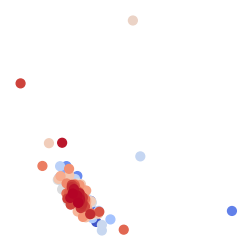

In [53]:
## Quick visualization to check its overview trend


fig = plt.figure(figsize=(3,3), dpi = 100)
ax = fig.add_subplot(111)
time_points = np.arange(lfads_embedding.shape[0])
sc = ax.scatter(lfads_embedding[:,0],
                lfads_embedding[:,1],
           c=time_points,
           cmap='coolwarm', s=40)

ax.grid(False)
ax.set_axis_off()

In [69]:
%cd lfads_demo/



[Errno 2] No such file or directory: 'lfads_demo/'
/home/cbi/wjbai/lfads-torch/lfads_demo


In [ ]:
%run run_sim.py

Using device: cuda
(401, 100, 100)
(401, 100, 100)
=== Run 01/10 ===
Random seed: 6753
Beginning training...


/home/cbi/wjbai/lfads-torch/lfads_demo/utils.py:91: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(open(path))


Epoch:    1, Step:     5, training loss: 9981.841, validation loss: 10910.515
Epoch:    2, Step:    10, training loss: 9322.038, validation loss: 10483.086
Epoch:    3, Step:    15, training loss: 9042.218, validation loss: 10000.094
Epoch:    4, Step:    20, training loss: 8764.722, validation loss: 9193.683
Epoch:    5, Step:    25, training loss: 8497.478, validation loss: 8619.742
Epoch:    6, Step:    30, training loss: 8238.989, validation loss: 8263.377
Epoch:    7, Step:    35, training loss: 8017.285, validation loss: 8019.731
Epoch:    8, Step:    40, training loss: 7841.438, validation loss: 7829.849
Epoch:    9, Step:    45, training loss: 7694.259, validation loss: 7682.039
Epoch:   10, Step:    50, training loss: 7581.180, validation loss: 7583.406
Epoch:   11, Step:    55, training loss: 7508.220, validation loss: 7538.751
Epoch:   12, Step:    60, training loss: 7455.792, validation loss: 7486.416
Epoch:   13, Step:    65, training loss: 7431.730, validation loss: 7448.

In [70]:
# Non-stitched mode
embeddings = np.load('sim_lfads_embeddings.npy')

embeddings.shape



(3, 10, 401, 2)